# Project - Kraftwerk

## Master Thesis

Clemens Wöhrer

# Teufelmühle - daily Prediction

---

# Install and Load Packages

In [1]:
!pip install --upgrade pip
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install sklearn
!pip install plotly
!pip install pmdarima
!pip install ipylab

In [2]:
%run functions.ipynb

In [3]:
np.random.seed(1234)
tf.random.set_seed(1234)

---

# Load Data

In [4]:
#Load folders
#lpd = Path("../Data/Lastprofildaten")
#wasser = Path("../Data/Wasserdaten")
#wetter = Path("../Data/Wetterdaten")
output = Path("../Data/Outputdaten")
forecast = Path("../Data/Forecast")

#Load csv names 
#mm_data = get_files(lpd, 'Lastprofil_Magerlmühle_*.csv')
#ps_data = get_files(lpd, 'Lastprofil_Pürnstein_*.csv')
#tm_data = get_files(lpd, 'Lastprofil_Teufelmühle_*.csv')
#wetter_files = get_files(wetter, '*.csv')
#wasser_files = get_files(wasser, '*.csv')

#Load dataframes from pickle
#mm_all = pd.read_pickle(os.path.join(output, "mm_all.pkl"))
#pm_all = pd.read_pickle(os.path.join(output, "pm_all.pkl"))
#tm_all = pd.read_pickle(os.path.join(output, "tm_all.pkl"))

In [5]:
data = pd.read_pickle(os.path.join(output, "pm_all.pkl"))

In [6]:
# Selecting Data greater than date 2019-03-01
data = data[data['timestamp'] >= '2019-03-01 00:00:00']

In [7]:
data.head()

timestamp   kw  Temperature  Growing_Degree_Days  \
10176 2019-03-01 00:00:00  0.0     8.650782                  0.0   
10177 2019-03-01 01:00:00  0.0     7.560782                  0.0   
10178 2019-03-01 02:00:00  0.0     6.960782                  0.0   
10179 2019-03-01 03:00:00  0.0     6.400782                  0.0   
10180 2019-03-01 04:00:00  0.0     6.080782                  0.0   

       Precipitation_Total  Snowfall_Amount  Relative_Humidity  Wind_Speed  \
10176                  0.0              0.0               85.0   28.822490   
10177                  0.0              0.0               89.0   29.091030   
10178                  0.0              0.0               90.0   28.387545   
10179                  0.0              0.0               88.0   29.871325   
10180                  0.0              0.0               88.0   26.552288   

       Wind_Direction  Wind_Gust  ...  Diffuse_Shortwave_Radiation  \
10176       279.34467  44.280000  ...                          0.0   
10177       282.14430  43.199997  ...                          0.0   
10178       282.45000  39.239998  ...                          0.0   
10179       282.52880  40.680000  ...                          0.0   
10180       282.52880  36.000000  ...                          0.0   

       Mean_Sea_Level_Pressure  Evapotranspiration  \
10176                   1014.0             0.00720   
10177                   1014.1             0.00720   
10178                   1014.4             0.00144   
10179                   1014.3             0.00288   
10180                   1013.8             0.00432   

       FAO_Reference_Evapotranspiration  Temperature  Soil_Temperature  \
10176                          0.023909         7.76          7.260010   
10177                          0.015030         5.97          6.899994   
10178                          0.012358         5.36          6.410004   
10179                          0.016309         4.87          5.959992   
10180                          0.014388         4.69          5.540008   

       Soil_Moisture  Vapor_Pressure_Deficit  waterlevel  watertemperature  
10176          0.287                1.650190     158.425             4.200  
10177          0.287                1.123480     158.725             4.125  
10178          0.288                0.980140     159.075             4.025  
10179          0.288                1.131616     159.450             3.925  
10180          0.288                1.106832     159.500             3.900  

[5 rows x 28 columns]

# Previous KW values to be used as features.

By moving KW values on certain lags, such as 1(move by 1 hour), 24(move by 1 day), 48(move by 2 days) and so on till move by a week, we have create few more features which are directly related to kw. We are interested to know that how these past value will affect present and future KW values. 


In [8]:
pp = data.set_index('timestamp')
pp["kw_1"] = pp["kw"].diff(24)
pp["kw_2"] = pp["kw"].diff(24*2)
pp["kw_3"] = pp["kw"].diff(24*3)
pp["kw_4"] = pp["kw"].diff(24*4)
pp["kw_5"] = pp["kw"].diff(24*5)
pp["kw_6"] = pp["kw"].diff(24*6)
pp["kw_7"] = pp["kw"].diff(24*7)
pp["kw_8"] = pp["kw"].diff(24*8)

---

# Data Info

In [9]:
# Checking Missing values in kw:

pp.query('kw != kw')

kw  Temperature  Growing_Degree_Days  \
timestamp                                                   
2019-03-31 02:00:00 NaN     7.330782                  0.0   
2020-03-29 02:00:00 NaN     5.840782                  0.0   
2021-03-28 02:00:00 NaN     2.130782                  0.0   

                     Precipitation_Total  Snowfall_Amount  Relative_Humidity  \
timestamp                                                                      
2019-03-31 02:00:00                  0.0              0.0               67.0   
2020-03-29 02:00:00                  0.0              0.0               77.0   
2021-03-28 02:00:00                  0.0              0.0               74.0   

                     Wind_Speed  Wind_Direction  Wind_Gust  Cloud_Cover_Total  \
timestamp                                                                       
2019-03-31 02:00:00    6.569383        9.462311  12.599999          10.200001   
2020-03-29 02:00:00   17.388409       27.095550  22.680000          10.000000   
2021-03-28 02:00:00    8.788720      304.992030  23.400000          77.000000   

                     ...  waterlevel  watertemperature  kw_1  kw_2  kw_3  \
timestamp            ...                                                   
2019-03-31 02:00:00  ...     159.900             6.575   NaN   NaN   NaN   
2020-03-29 02:00:00  ...     142.175             6.875   NaN   NaN   NaN   
2021-03-28 02:00:00  ...     136.700             4.850   NaN   NaN   NaN   

                     kw_4  kw_5  kw_6  kw_7  kw_8  
timestamp                                          
2019-03-31 02:00:00   NaN   NaN   NaN   NaN   NaN  
2020-03-29 02:00:00   NaN   NaN   NaN   NaN   NaN  
2021-03-28 02:00:00   NaN   NaN   NaN   NaN   NaN  

[3 rows x 35 columns]

In [10]:
# Replace Null-Values with forward fill and then backward fill
data_sum = pp.resample("D").sum()
pp=pp.fillna(method="pad")
pp=pp.fillna(method="bfill")
# Methode:
#  pad = forwardfill method


In [11]:
pp.head(20)

kw  Temperature  Growing_Degree_Days  \
timestamp                                                    
2019-03-01 00:00:00  0.0     8.650782                  0.0   
2019-03-01 01:00:00  0.0     7.560782                  0.0   
2019-03-01 02:00:00  0.0     6.960782                  0.0   
2019-03-01 03:00:00  0.0     6.400782                  0.0   
2019-03-01 04:00:00  0.0     6.080782                  0.0   
2019-03-01 05:00:00  0.0     6.310782                  0.0   
2019-03-01 06:00:00  0.0     5.440782                  0.0   
2019-03-01 07:00:00  0.0     5.270782                  0.0   
2019-03-01 08:00:00  0.0     5.410782                  0.0   
2019-03-01 09:00:00  0.0     6.520782                  0.0   
2019-03-01 10:00:00  0.0     6.930782                  0.0   
2019-03-01 11:00:00  0.0     7.310782                  0.0   
2019-03-01 12:00:00  0.0     7.560782                  0.0   
2019-03-01 13:00:00  0.0     7.870782                  0.0   
2019-03-01 14:00:00  0.0     8.820782                  0.0   
2019-03-01 15:00:00  0.0     8.930781                  0.0   
2019-03-01 16:00:00  0.0     9.080782                  0.0   
2019-03-01 17:00:00  0.0     8.290782                  0.0   
2019-03-01 18:00:00  0.0     7.940782                  0.0   
2019-03-01 19:00:00  0.0     5.840782                  0.0   

                     Precipitation_Total  Snowfall_Amount  Relative_Humidity  \
timestamp                                                                      
2019-03-01 00:00:00                  0.0              0.0               85.0   
2019-03-01 01:00:00                  0.0              0.0               89.0   
2019-03-01 02:00:00                  0.0              0.0               90.0   
2019-03-01 03:00:00                  0.0              0.0               88.0   
2019-03-01 04:00:00                  0.0              0.0               88.0   
2019-03-01 05:00:00                  0.0              0.0               91.0   
2019-03-01 06:00:00                  0.0              0.0               93.0   
2019-03-01 07:00:00                  0.0              0.0               94.0   
2019-03-01 08:00:00                  0.0              0.0               94.0   
2019-03-01 09:00:00                  0.0              0.0               88.0   
2019-03-01 10:00:00                  0.0              0.0               86.0   
2019-03-01 11:00:00                  0.0              0.0               84.0   
2019-03-01 12:00:00                  0.2              0.0               80.0   
2019-03-01 13:00:00                  0.0              0.0               76.0   
2019-03-01 14:00:00                  0.4              0.0               78.0   
2019-03-01 15:00:00                  0.4              0.0               76.0   
2019-03-01 16:00:00                  0.4              0.0               75.0   
2019-03-01 17:00:00                  0.1              0.0               79.0   
2019-03-01 18:00:00                  0.0              0.0               81.0   
2019-03-01 19:00:00                  0.0              0.0               91.0   

                     Wind_Speed  Wind_Direction  Wind_Gust  Cloud_Cover_Total  \
timestamp                                                                       
2019-03-01 00:00:00   28.822490       279.34467  44.280000              100.0   
2019-03-01 01:00:00   29.091030       282.14430  43.199997               11.0   
2019-03-01 02:00:00   28.387545       282.45000  39.239998               10.0   
2019-03-01 03:00:00   29.871325       282.52880  40.680000               14.0   
2019-03-01 04:00:00   26.552288       282.52880  36.000000               80.0   
2019-03-01 05:00:00   21.267440       272.91083  33.480000              100.0   
2019-03-01 06:00:00   22.725668       273.63297  33.480000               55.0   
2019-03-01 07:00:00   20.163212       268.97700  31.319998              100.0   
2019-03-01 08:00:00   19.469976       266.82020  26.640000              100.0   
2019-

In [12]:
pp.describe()

kw   Temperature  Growing_Degree_Days  Precipitation_Total  \
count  21960.000000  21960.000000         21960.000000         21960.000000   
mean      52.820971     11.036571             0.158764             0.059312   
std       29.282821      7.826366             0.205264             0.319866   
min        0.000000    -10.769218             0.000000             0.000000   
25%       29.964000      4.810782             0.000000             0.000000   
50%       52.291500     10.920782             0.038366             0.000000   
75%       75.774750     16.983283             0.290970             0.000000   
max      113.844000     31.770782             0.833333            11.000000   

       Snowfall_Amount  Relative_Humidity    Wind_Speed  Wind_Direction  \
count     21960.000000       21960.000000  21960.000000    21960.000000   
mean          0.003726          72.248907     13.710826      185.858631   
std           0.057767          16.160813      9.460353      106.381861   
min           0.000000          17.000000      0.000000        0.550888   
25%           0.000000          60.000000      6.725354       85.100910   
50%           0.000000          73.000000     11.525623      205.968055   
75%           0.000000          86.000000     18.514643      277.495850   
max           3.220000         100.000000     76.594600      360.000000   

          Wind_Gust  Cloud_Cover_Total  ...    waterlevel  watertemperature  \
count  21960.000000       21960.000000  ...  21960.000000      21960.000000   
mean      19.087196          47.294422  ...    136.938102          9.170783   
std       11.605633          45.091160  ...     19.489470          5.420111   
min        0.000000           0.000000  ...    110.225000         -0.200000   
25%       10.799999           0.600000  ...    124.625000          4.575000   
50%       17.280000          30.000002  ...    132.325000          8.850000   
75%       24.480000         100.000000  ...    142.600000         13.325000   
max       85.320000         100.000000  ...    326.750000         23.250000   

               kw_1          kw_2          kw_3          kw_4          kw_5  \
count  21960.000000  21960.000000  21960.000000  21960.000000  21960.000000   
mean       0.064848      0.146928      0.251821      0.358304      0.446925   
std       19.832001     25.157592     27.386308     27.825303     26.917818   
min     -109.167000   -111.153000   -102.369000   -101.148000   -105.723000   
25%       -6.708000    -10.854750    -13.374000    -14.493000    -14.343750   
50%       -0.784500     -0.771000     -1.056000     -1.188000     -1.729500   
75%        6.852000     11.859000     14.442000     15.284250     14.180250   
max      108.387000    107.094000    109.917000    110.412000    105.672000   

               kw_6          kw_7          kw_8  
count  21960.000000  21960.000000  21960.000000  
mean       0.774042      0.821789      1.156167  
std       25.315451     23.339792     26.306871  
min     -101.763000   -102.699000   -104.787000  
25%      -13.044750    -11.952750    -13.186500  
50%       -1.689000     -0.874500     -0.637500  
75%       13.386000     11.709750     13.570500  
max      103.176000    105.597000    109.266000  

[8 rows x 35 columns]

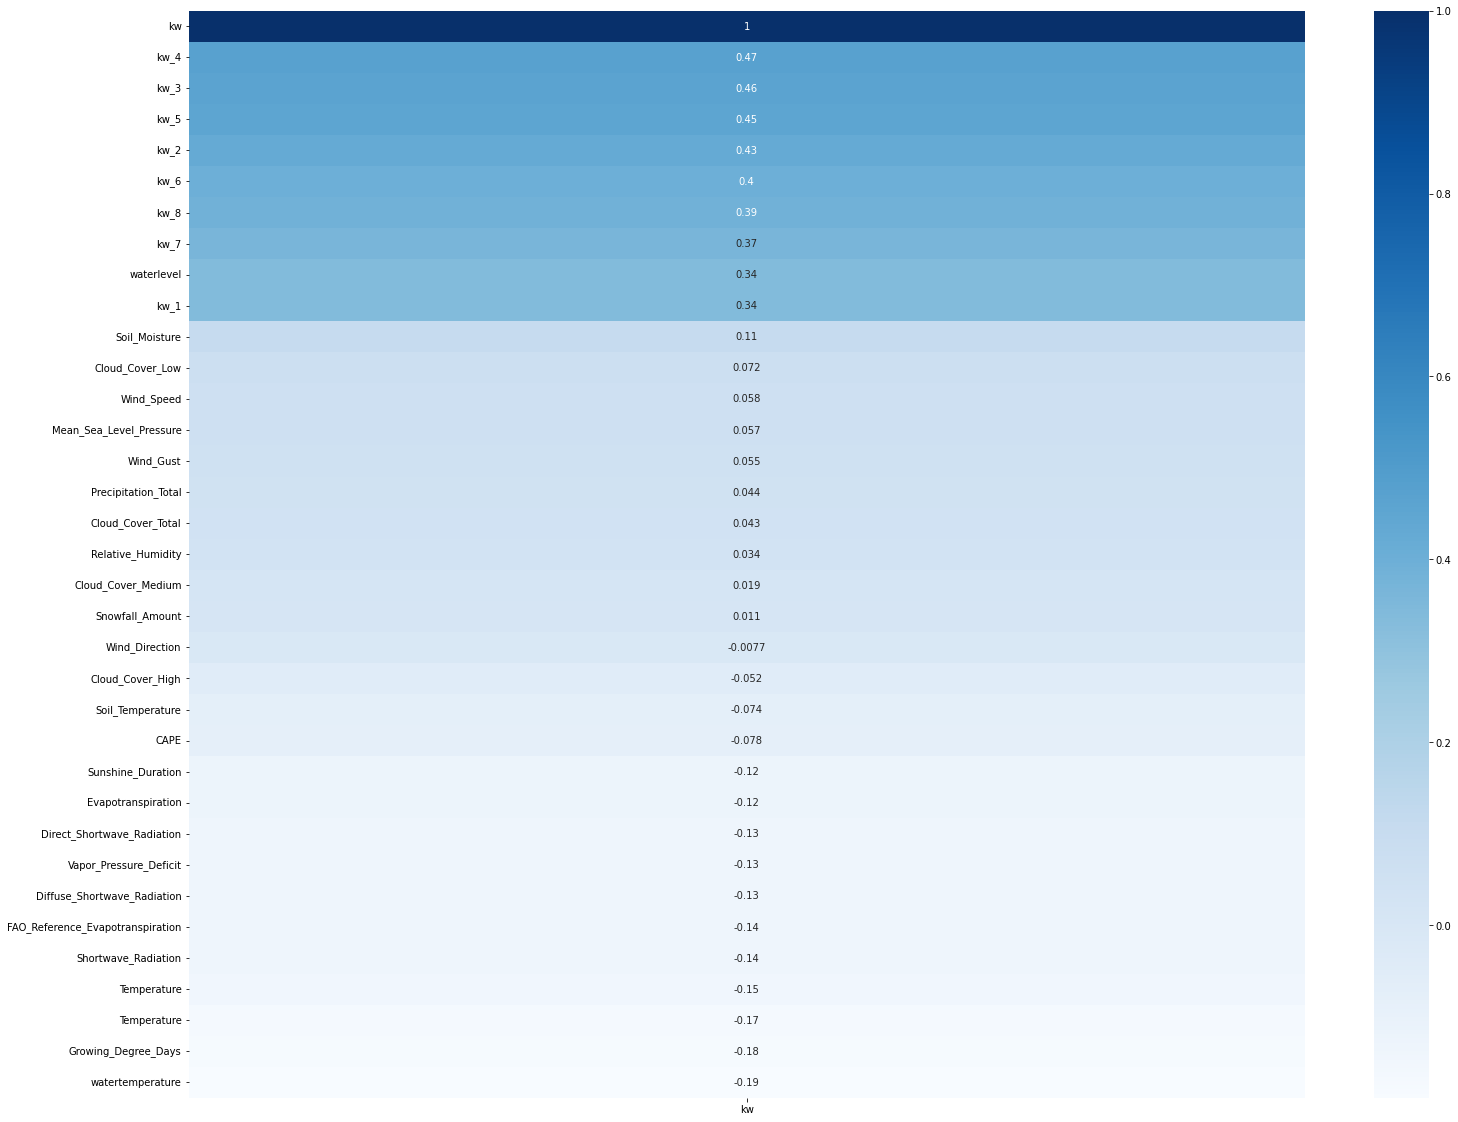

In [13]:
cor_matrix = pp.corr()
cor_matrix[['kw']]

f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(cor_matrix[['kw']].sort_values(by=['kw'], ascending =False), annot=True, cmap="Blues")
plt.show()

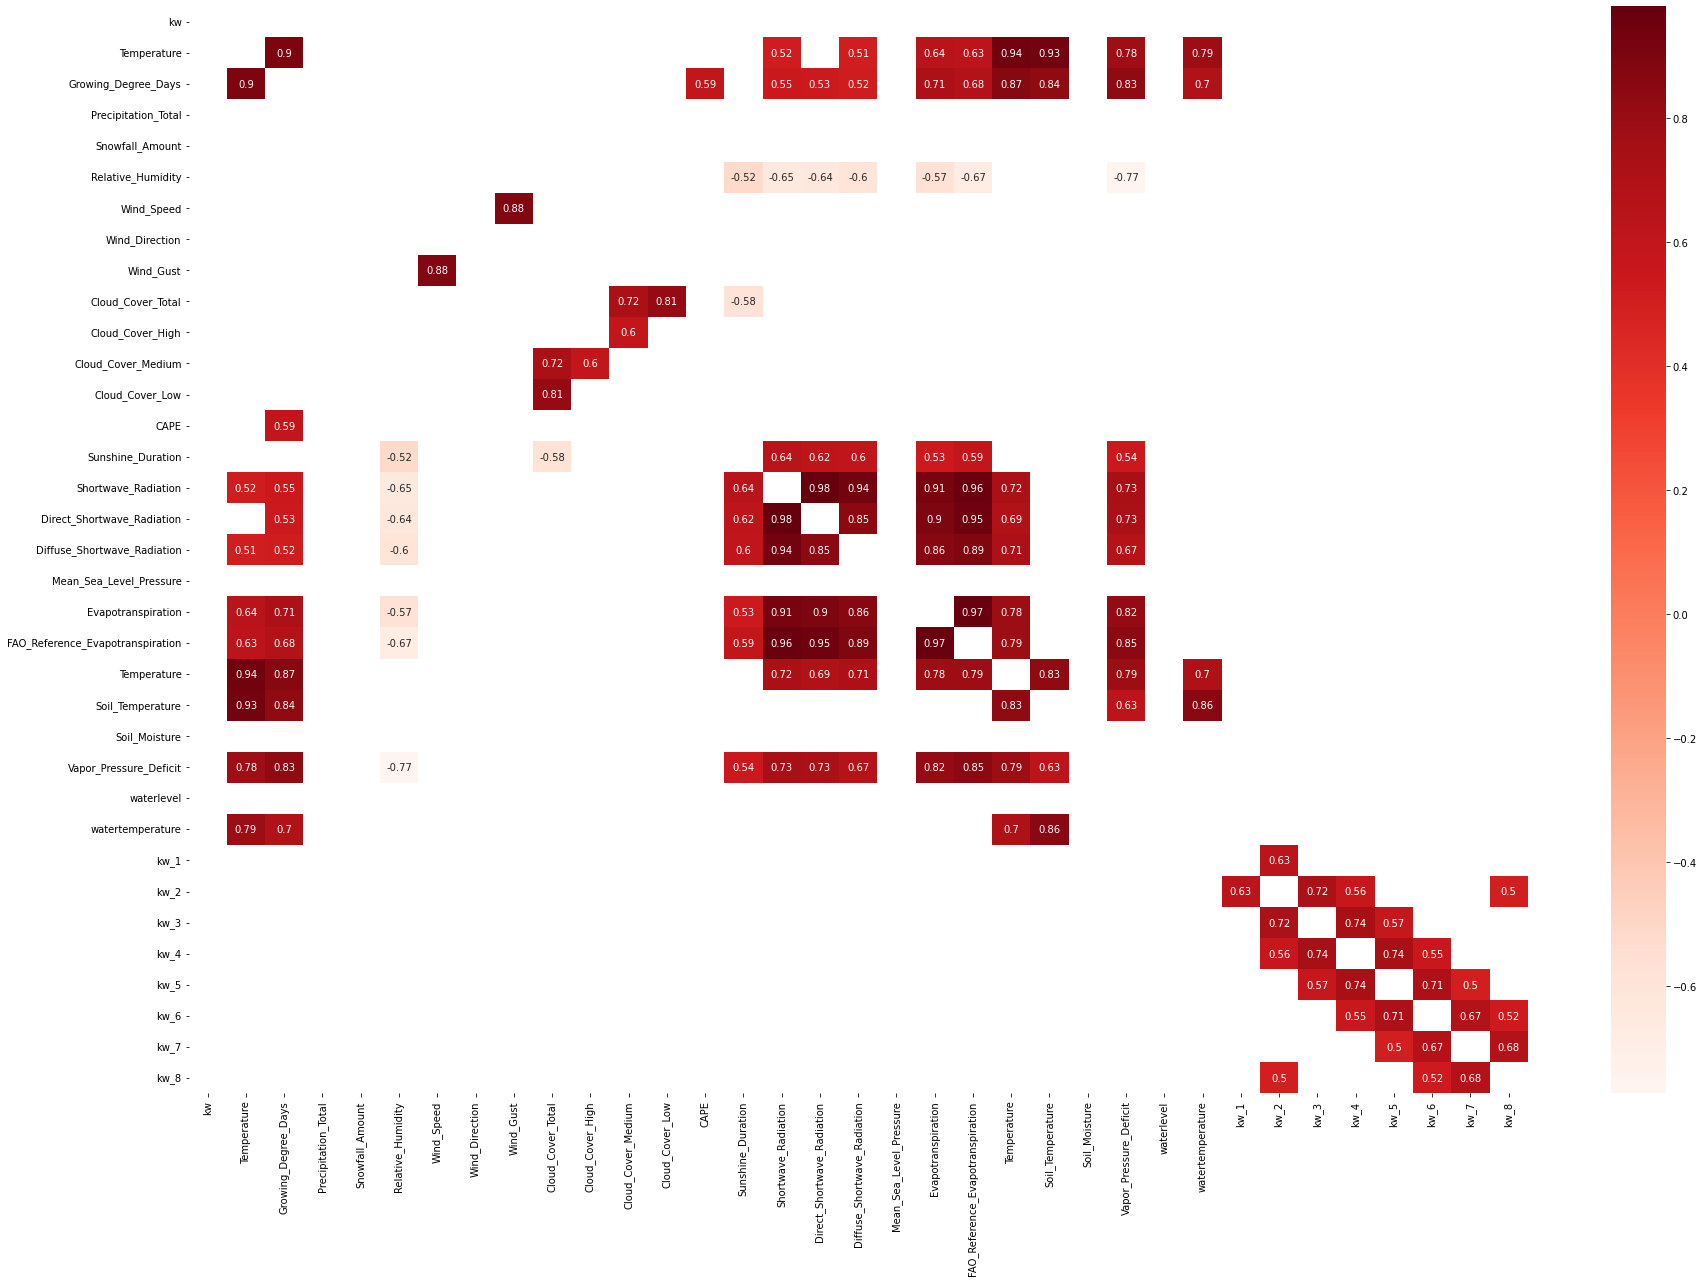

In [14]:
filteredDf = cor_matrix[((cor_matrix >= .5) | (cor_matrix <= -.5)) & (cor_matrix !=1.000)]
plt.figure(figsize=(30,20))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
#plt.savefig('matrix.jpeg')
plt.show()


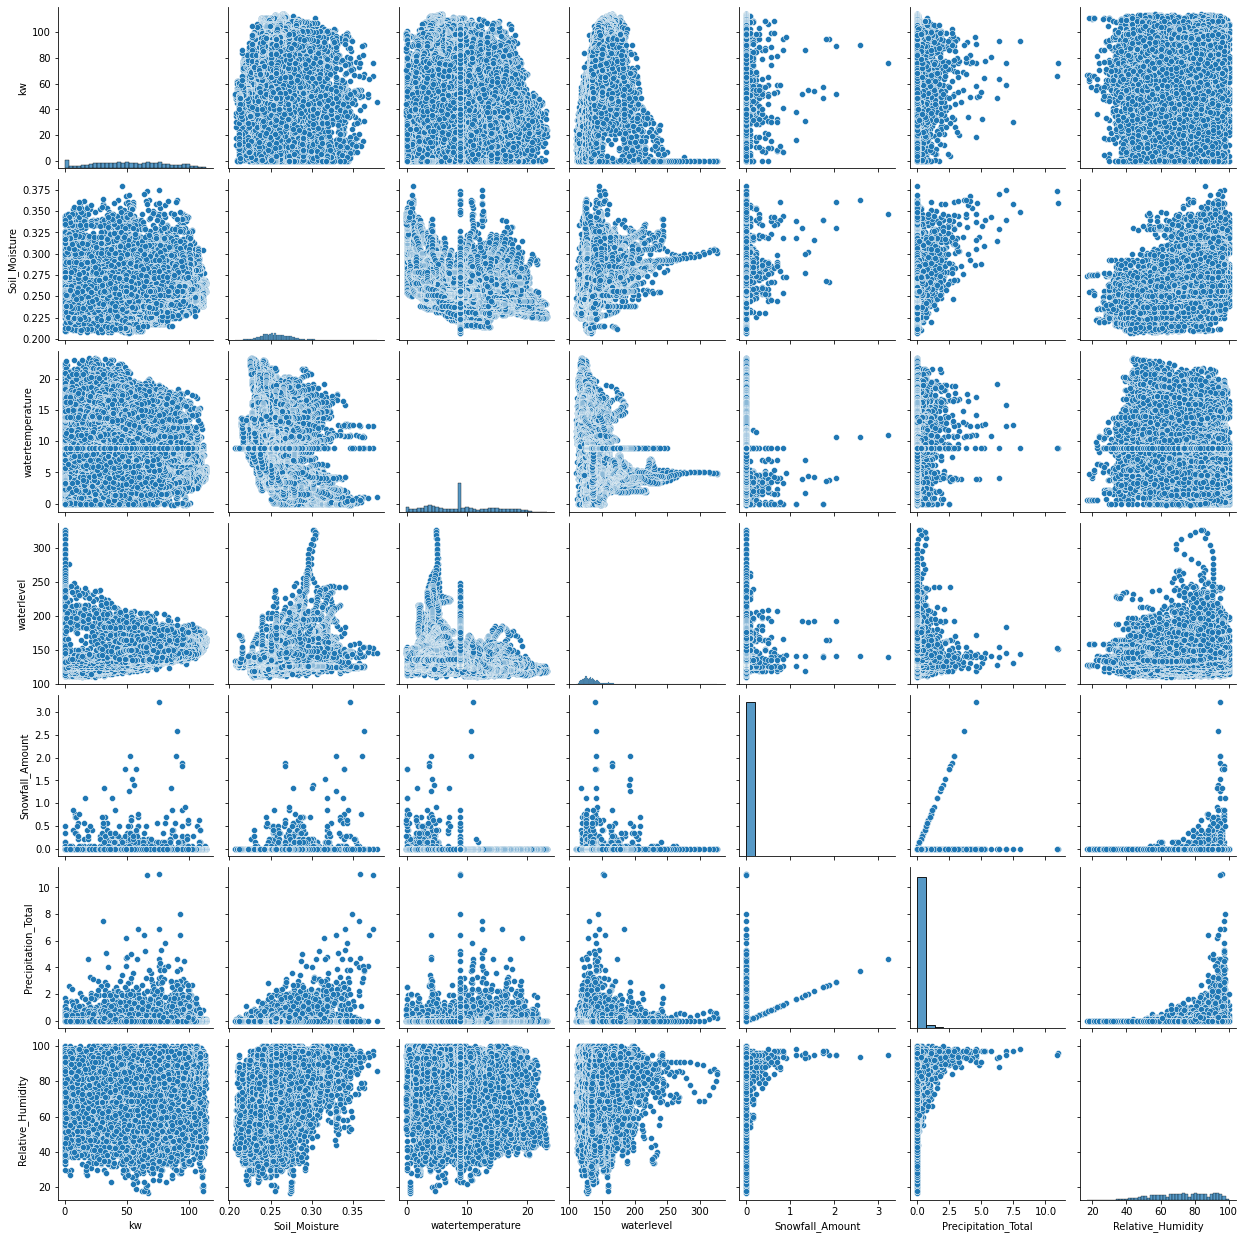

In [15]:
sns.pairplot(pp[['kw', "Soil_Moisture", "watertemperature","waterlevel",
                 "Snowfall_Amount", "Precipitation_Total", "Relative_Humidity"]])
plt.show()

The heatmap shows that past lag values of kw certain affect present kw values.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


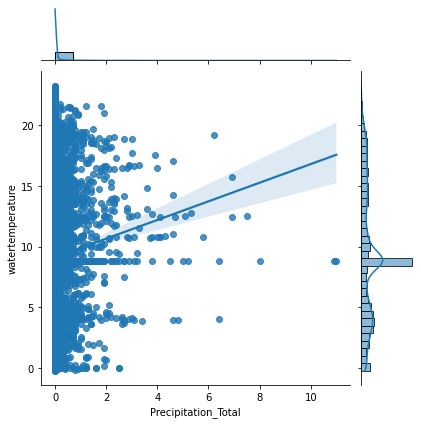

In [16]:
sns.jointplot("Precipitation_Total", "watertemperature", data=pp, kind='reg');

In [17]:
fit1 = np.polyfit(pp["Soil_Moisture"], pp["Precipitation_Total"], 1)  # linear
fit2 = np.polyfit(pp["Soil_Moisture"], pp["Precipitation_Total"], 2)  # quadratic
fit3 = np.polyfit(pp["Soil_Moisture"], pp["Precipitation_Total"], 3)  # cubic

v1 = np.polyval(fit1, pp["Soil_Moisture"])
v2 = np.polyval(fit2, pp["Soil_Moisture"])
v3 = np.polyval(fit3, pp["Soil_Moisture"])

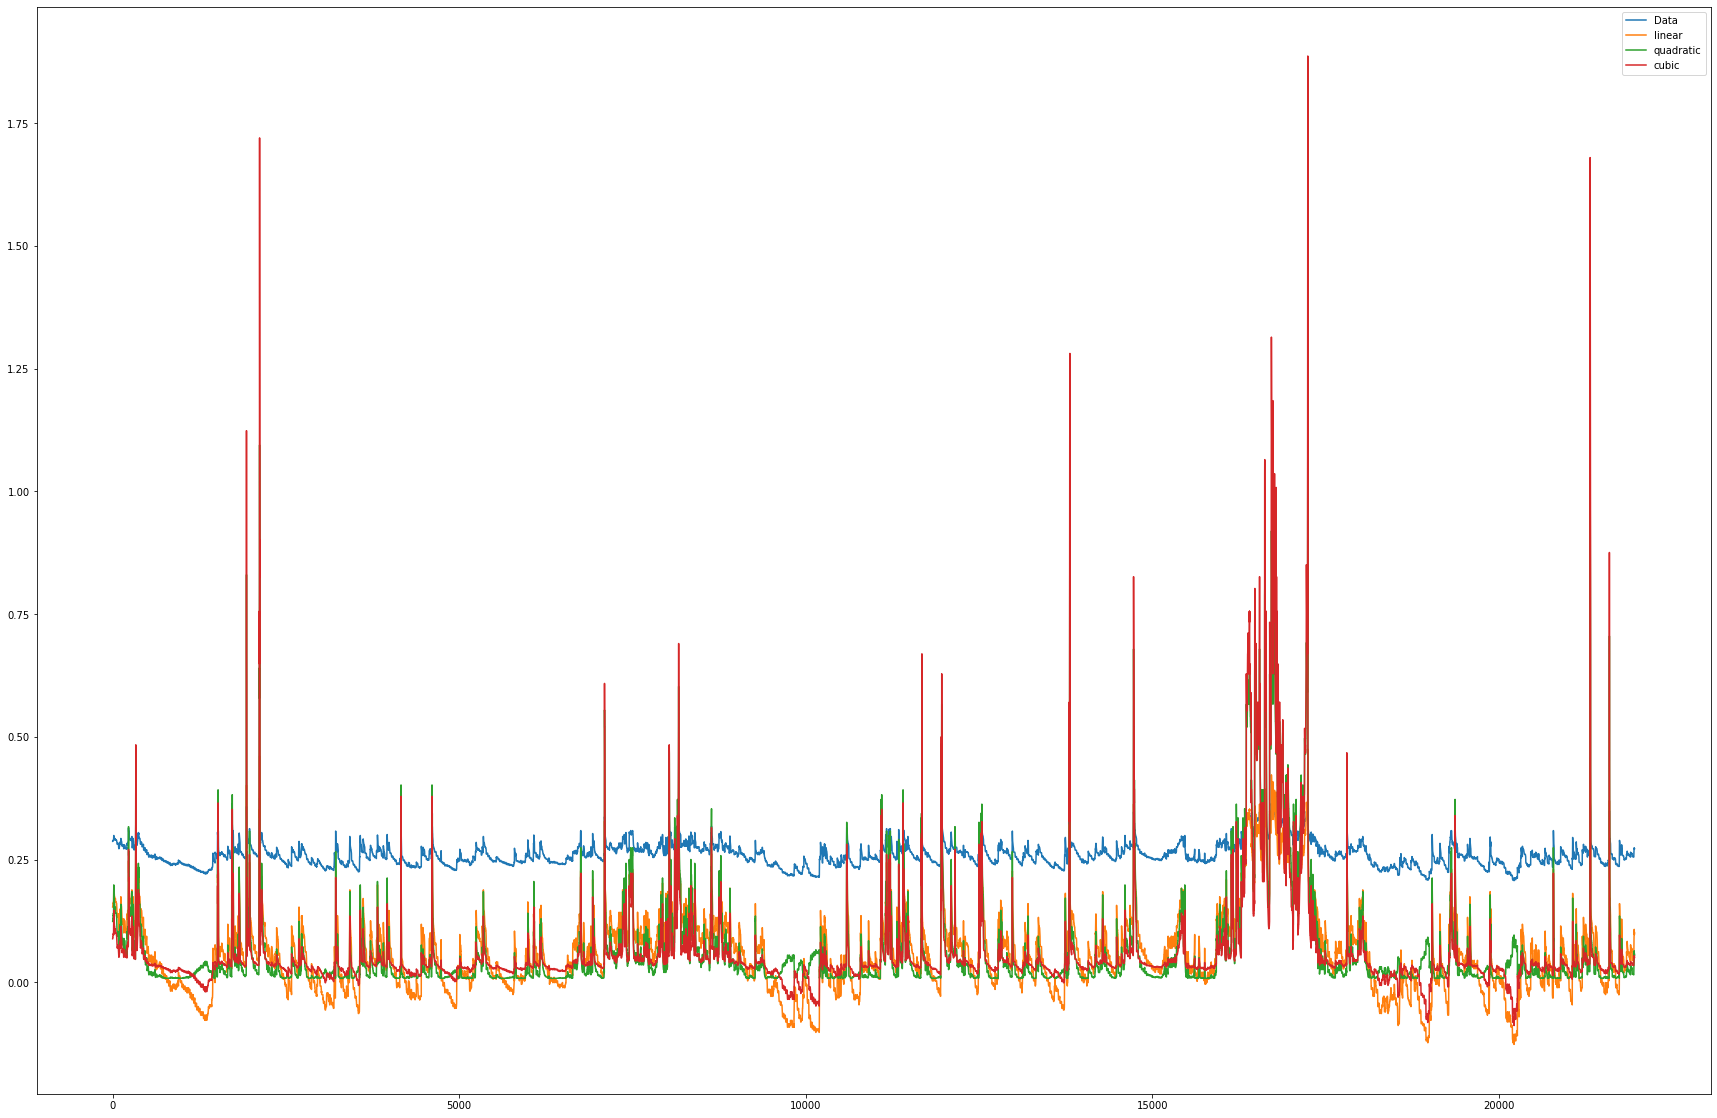

In [18]:
plt.figure(figsize=(30,20))
plt.plot(pp["Soil_Moisture"].values, label="Data")
plt.plot(v1, label = "linear")
plt.plot(v2, label = "quadratic")
plt.plot(v3, label = "cubic")
plt.legend()
plt.show()

In [19]:
def data_split(data, test_size):
    split = len(data)-test_size
    train = data[:split]
    test = data[split:]
    
    return (train, test)


In [20]:
# Split_sequence Function: Arguments
# This function will prepare time series data to be used in LSTM model.
# The function takes defined number of time steps and then calculates all samples of same length.

# Arguments:

# sequence: This is the dataset length, which will be used to calculate batches.
# n_steps_in : provide time steps to be used to predict future time steps
# n_steps_out: How many hours/days you want to predict in future. Right now it's 72 hours.

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
# The below function provides general lstm model structure.
# This function will take two argument values:

# 1. n-neurons: Right now we are using 50 neurons, but it can increased or decreased 
# to check if it affects model results.

# 2. lr = Learning rate: The learning rate is an important parameter, it seems that
# smaller values decrease model overfitting

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


def build_lstm_model(n_neurons, lr, n_steps_in, n_features, n_steps_out):
    opt = keras.optimizers.Adam(learning_rate=lr)
    
    model = Sequential()
    
    model.add(LSTM(n_neurons, return_sequences=True, activation='tanh',
                   input_shape=(n_steps_in, n_features)))
    model.add(Dropout(0.3))
    
    model.add(LSTM(units=n_neurons, activation='tanh'))
    model.add(Dropout(0.3))
    
    model.add(Dense(n_steps_out, activation='linear'))
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()
    
    return model



%history -g -f history.py

In [22]:
# Data Normalization: Has to be done for better predictions. All columns values range will be between 0 and 1.

def prepare_time_series(X, y, input_steps=7, output_steps=7, past=3):
    
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    x_scaled = scaler1.fit_transform(X)
    y_scaled = scaler1.fit_transform(y.reshape((len(y), 1)))
    
    dataset_stacked = hstack((x_scaled, y_scaled))
    print ("dataset_stacked.shape" , dataset_stacked.shape)
    
    # choose a number of time steps # change this accordingly

    n_steps_in, n_steps_out = input_steps*past, output_steps 

    # covert into input/output
    x, Y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)

    print ("X.shape" , X.shape) 
    print ("y.shape" , y.shape) 
    
    return(x, Y)

In [23]:
def train_test_split(X, y, split_size=0.9):
    
    split_point = int(len(X)*split_size)
    train_X , train_y = X[:split_point, :] , y[:split_point, :]
    test_X , test_y = X[split_point:, :] , y[split_point:, :]

    n_features = train_X.shape[2]
    
    print ("train_X.shape" , train_X.shape) 
    print ("train_y.shape" , train_y.shape)  
    print ("test_X.shape" , test_X.shape) 
    print ("test_y.shape" , test_y.shape) 
    print ("n_features" , n_features)
    
    return(train_X, train_y, test_X, test_y)

### LSTM Model for daily data

As now dataset has become much smaller, we can try large number of parameters on this model.

## Grid Sarch Method to find Optimal parameters

The below code will apply random cross validation method to find optimal parameters:
1. n-neurons: Right now we are using 50 neurons, but it can increased or decreased 
to check if it affects model results.

2. lr = Learning rate: The learning rate is an important parameter, it seems that smaller values decrease
model overfitting

3. batch_size: One batch contains 720 time steps, so it size should be a small number. Between 10-20 at maximum

4. epoch size: I have go with 100 epoch size, but we can add other number of epochs to look for better model

All these parameters are combined in dict to fed to RandomizedSearchCV method.

In the last steps the models we build with random search cv, are fitted to the data.

### Fit Different parameters and find best model.

In [24]:
# define the grid search parameters
learning_rate = [0.01, 0.001]
neurons = [50]
batch_size = [112, 128]
epoch = [200]
params_distrib = dict(batch_size=batch_size, n_neurons=neurons, lr=learning_rate,
                     epochs=epoch)
    
def cross_validation(train_x, train_y, valid_x, valid_y, params_distrib=params_distrib):
    n_steps_in, n_features, n_steps_out = train_x.shape[1], train_x.shape[2], valid_y.shape[1]
    keras_reg1 = KerasRegressor(build_lstm_model, n_steps_in = n_steps_in, n_features=n_features,
                                       n_steps_out=n_steps_out)

    rnd_search_cv = RandomizedSearchCV(keras_reg1, params_distrib, cv=3,n_iter=2,
                                       scoring="r2")
    grid_result = rnd_search_cv.fit(train_x, train_y, epochs=50, 
                    validation_data=(valid_x, valid_y))
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("Mean: %f (Standard Deviation: %f) with: %r" % (mean, stdev, param))
    
    # Accuracy and loss
    fig = plt.figure(figsize=(20,7))
    fig.add_subplot(121)
    plt.plot(grid_result.best_estimator_.model.history.history['root_mean_squared_error'])
    plt.plot(grid_result.best_estimator_.model.history.history['val_root_mean_squared_error'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    #Adding Subplot 1 (For Loss)
    fig.add_subplot(122)

    plt.plot(grid_result.best_estimator_.model.history.history['loss'], label="loss")
    plt.plot(grid_result.best_estimator_.model.history.history['val_loss'], label="val_loss")

    plt.title("Loss", fontsize=18)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.grid(alpha=0.3)
    plt.legend()

    plt.show()
    return grid_result

In [25]:
## Daily Data
#daily_mean = pp.resample("D").mean()
daily_sum = pp.resample("D").sum()
# Replace Null-Values with forward fill and then backward fill
daily_sum = daily_sum.fillna(method="pad")
daily_sum = daily_sum.fillna(method="bfill")
# Methode:
#  pad = forwardfill method

daily_mean = pp.resample("D").mean()
# Replace Null-Values with forward fill and then backward fill
daily_mean = daily_mean.fillna(method="pad")
daily_mean = daily_mean.fillna(method="bfill")


daily_mean["kw"] = daily_sum["kw"]

In [26]:
daily_mean

kw  Temperature  Growing_Degree_Days  Precipitation_Total  \
timestamp                                                                     
2019-03-01     0.000     6.821199             0.000000             0.062500   
2019-03-02     0.000     5.084948             0.000000             0.012500   
2019-03-03     0.000     7.865782             0.024159             0.000000   
2019-03-04     0.003     8.791199             0.038551             0.004167   
2019-03-05     0.000     4.484532             0.000000             0.145833   
...              ...          ...                  ...                  ...   
2021-08-27  1944.795    12.164949             0.090967             0.075000   
2021-08-28  2340.027    11.880782             0.083726             0.050000   
2021-08-29  2305.545    11.482032             0.079674             0.016667   
2021-08-30  1799.955    11.899532             0.102383             0.004167   
2021-08-31  1426.374    12.715365             0.116713             0.137500   

            Snowfall_Amount  Relative_Humidity  Wind_Speed  Wind_Direction  \
timestamp                                                                    
2019-03-01         0.000000          86.500000   21.787742      280.228151   
2019-03-02         0.000000          85.583333   16.871847      276.715073   
2019-03-03         0.000000          76.750000   20.003412      255.585232   
2019-03-04         0.000000          54.000000   22.136188      237.544430   
2019-03-05         0.046667          74.833333   36.494434      262.704009   
...                     ...                ...         ...             ...   
2021-08-27         0.000000          82.125000   14.766507      269.696408   
2021-08-28         0.000000          83.875000   10.308295      256.368468   
2021-08-29         0.000000          83.125000    7.238094      287.581941   
2021-08-30         0.000000          86.750000    7.249628      267.800614   
2021-08-31         0.000000          88.250000   12.347382      298.120639   

            Wind_Gust  Cloud_Cover_Total  ...  waterlevel  watertemperature  \
timestamp                                 ...                                 
2019-03-01  30.869999          65.500000  ...  167.810417          4.064583   
2019-03-02  25.304999          86.833333  ...  199.545833          3.155208   
2019-03-03  31.499999          78.275000  ...  194.609375          3.963542   
2019-03-04  42.074999          51.245833  ...  194.091667          4.235417   
2019-03-05  49.184998          65.816667  ...  197.090625          4.263542   
...               ...                ...  ...         ...               ...   
2021-08-27  19.770000          93.125000  ...  178.397917          8.850000   
2021-08-28  15.149999          95.208333  ...  177.117708          8.850000   
2021-08-29  10.665000          74.575000  ...  175.802083          8.850000   
2021-08-30  10.995000          61.941667  ...  168.981250          8.850000   
2021-08-31  19.034999          71.458333  ...  186.444792          8.850000   

                 kw_1       kw_2       kw_3       kw_4      kw_5       kw_6  \
timestamp                                                                     
2019-03-01   0.000000   0.000000   0.000000   0.000000   0.00000  41.277000   
2019-03-02   0.000000   0.000000   0.000000   0.000000   0.00000  41.277000   
2019-03-03   0.000000   0.000000   0.000000   0.000000   0.00000  41.277000   
2019-03-04   0.000125   0.000125   0.000125   0.000000   0.00000  41.277000   
2019-03-05  -0.000125   0.000000   0.000000   0.000000   0.00000  41.277000   
...               ...        ...        ...        ...       ...        ...   
2021-08-27  11.124125   1.716500   3.997250   5.814500   9.67600  11.047750   
2021-08-28  16.468000  27.592125  18.184500  20.465250  22.28250  26.144000   
2021-08-29  -1.436750  15.031250  26.155375  16.747750  19.02850  20.845750   
2021-08-30 -21.066250 -22.503000  -6.035000   5.089125  -4.31850  -2.037750   

In [27]:
# Data Preparation:
# X needs to be 25 stamps ahead, and kw needs to be same

# new dataset without Test values
data, Test = data_split(daily_mean, (30+21))

# Now shift values by * days, however as only need x features shifted, we will drop kw from this data and then add
# it again from original data with first time stamp

df = data.shift(-8)
df = df.fillna(method="pad")
df["kw"] = data["kw"]
df["kw_8"] = data["kw_8"]

test_df = Test.shift(-8)
test_df=test_df.fillna(method="pad")
test_df["kw"] = Test["kw"]
test_df["kw_8"] = Test["kw_8"]

In [28]:
import plotly.express as px
fig = px.line(daily_sum, x=daily_sum.index, y='kw', title='Production')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='1y', step='year', stepmode='backward'),
            dict(count=2, label='3y', step='year', stepmode='backward'),
            dict(count=3, label='5y', step='year', stepmode='backward'),
            dict(step='all')
            ])
    )
)
fig.show()

## Model 1: All Features with shifting features values to 8 days in future

In [29]:
x1 = df.values
y = data["kw"].values


X, Y = prepare_time_series(x1, y)

X_train, y_train, x_test, y_test = train_test_split(X, Y)

dataset_stacked.shape (864, 36)
X.shape (864, 35)
y.shape (864,)
train_X.shape (754, 21, 35)
train_y.shape (754, 7)
test_X.shape (84, 21, 35)
test_y.shape (84, 7)
n_features 35


2021-12-12 21:30:14.379299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:30:14.392570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:30:14.393673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:30:14.396313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 21:30:14.397364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 50)            17200     
_________________________________________________________________
dropout (Dropout)            (None, 21, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 7)                 357       
Total params: 37,757
Trainable params: 37,757
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2021-12-12 21:30:16.026795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-12 21:30:19.279650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


5/5 [==============================] - 5s 164ms/step - loss: 0.1909 - root_mean_squared_error: 0.4369 - val_loss: 0.0550 - val_root_mean_squared_error: 0.2346
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0817 - root_mean_squared_error: 0.2857 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1761
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0597 - root_mean_squared_error: 0.2443 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1754
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0537 - root_mean_squared_error: 0.2317 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1807
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0427 - root_mean_squared_error: 0.2065 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1903
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0403 - root_mean_squared_error: 0.2008 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1

5/5 [==============================] - 0s 14ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 50/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 21, 50)            17200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
________________________________________________________

5/5 [==============================] - 0s 12ms/step - loss: 0.0102 - root_mean_squared_error: 0.1012 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 42/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 43/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1037
Epoch 44/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 45/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0083 - root_mean_squared_error: 0.0914 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 46/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0086 - val_root_mean_squared_error:

5/5 [==============================] - 0s 11ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 34/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0122 - root_mean_squared_error: 0.1107 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 35/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296
Epoch 36/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 37/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1370
Epoch 38/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.0203 - val_root_mean_squared_error:

5/5 [==============================] - 0s 11ms/step - loss: 0.0248 - root_mean_squared_error: 0.1573 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1483
Epoch 26/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0254 - root_mean_squared_error: 0.1595 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1437
Epoch 27/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0238 - root_mean_squared_error: 0.1541 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438
Epoch 28/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0231 - root_mean_squared_error: 0.1519 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1445
Epoch 29/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0237 - root_mean_squared_error: 0.1538 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1393
Epoch 30/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0233 - root_mean_squared_error: 0.1528 - val_loss: 0.0188 - val_root_mean_squared_error:

5/5 [==============================] - 0s 11ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682
Epoch 18/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0290 - root_mean_squared_error: 0.1702 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1515
Epoch 19/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0272 - root_mean_squared_error: 0.1649 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484
Epoch 20/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0269 - root_mean_squared_error: 0.1641 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1603
Epoch 21/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0257 - root_mean_squared_error: 0.1603 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 22/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - val_loss: 0.0239 - val_root_mean_squared_error:

Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0529 - root_mean_squared_error: 0.2301 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 6/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0489 - root_mean_squared_error: 0.2210 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1877
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0393 - root_mean_squared_error: 0.1983 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1843
Epoch 8/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0357 - root_mean_squared_error: 0.1890 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1660
Epoch 9/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0367 - root_mean_squared_error: 0.1916 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1637
Epoch 10/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0324 - root_mean_squared_error: 0.1799 - val_loss: 0.0286 - val_root_mean_squared

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 21, 50)            17200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 357       
Total params: 37,757
Trainable params: 37,757
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7/7 [==============================] - 3s 97ms/step - loss: 0.1964 - root_mean_squared_error: 0.4432 - va

7/7 [==============================] - 0s 15ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0877
Epoch 44/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 45/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832
Epoch 46/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783
Epoch 47/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0765
Epoch 48/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0070 - val_root_mean_squared_error: 0

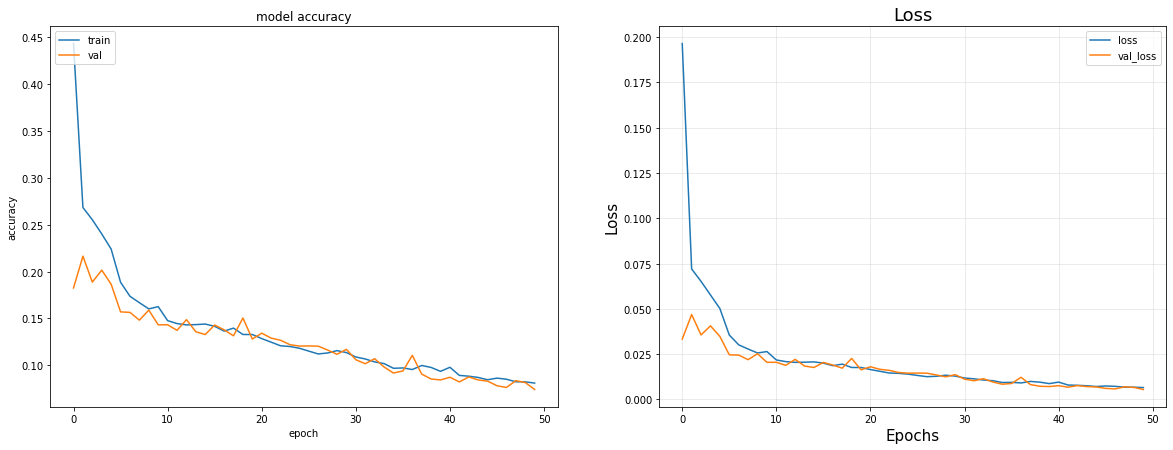

In [30]:
results1 = cross_validation(X_train, y_train, x_test, y_test)

In [31]:
# TEST DATA Fucntions

def prep_data(x, y_test , start , end , last, model, n_steps_out=7):
    #prepare test data X
    dataset_test_X = x[start:end, :]
    test_X_new = dataset_test_X.reshape(1,dataset_test_X.shape[0],dataset_test_X.shape[1])
    past_data = y_test[:end]
    dataset_test_y = y_test[end:last]
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    scaler1.fit(dataset_test_y.values.reshape(-1, 1))
    y_pred = model.predict(test_X_new).reshape(-1, 1)
    y_pred_inv = scaler1.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]
    
    return y_pred_inv , dataset_test_y , past_data


def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    r2 = 1-(sum(errors**2)/sum((actual-np.mean(actual))**2))
    print("Test Data from {} to {}".format(str(start), str(end)))
    print('Mean Square Error: {:.2f}'.format(mse))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('R-Square: {:.2f}'.format(r2_score(actual,predictions)))
    print('')
    print('')
    d = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R^2": r2}
    data = pd.DataFrame(d, index=[str(start)+" : "+str(end)])
    
    return(data)

In [32]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    
    y_mean = mean(prediction1)
    
    plt.plot(history.index, np.array(history), label='History')
    plt.plot(groundtruth.index, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(groundtruth.index, np.array(groundtruth),label='GroundTruth')
    
    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(history.index[0],
                               groundtruth.index[-1], y_mean) ,  fontsize=18)
    plt.xlabel('Time stamp' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)


In [33]:

x_test = test_df.values
y_test = test_df['kw']


scaler = MinMaxScaler(feature_range=(0, 1))

test_scaled = scaler.fit_transform(x_test)


start = 0
end = start + 14
last = end + 7
y_pred_inv , dataset_test_y , past_data = prep_data(test_scaled, y_test , start , end , last, results1)

Test Data from 2021-08-02 00:00:00 to 2021-08-08 00:00:00
Mean Square Error: 114203.41
Mean Absolute Error: 300.31
Root Mean Square Error: 337.94
R-Square: -0.39


Test Data from 2021-08-09 00:00:00 to 2021-08-15 00:00:00
Mean Square Error: 24972.40
Mean Absolute Error: 141.92
Root Mean Square Error: 158.03
R-Square: -0.90


Test Data from 2021-08-16 00:00:00 to 2021-08-22 00:00:00
Mean Square Error: 7732.23
Mean Absolute Error: 79.23
Root Mean Square Error: 87.93
R-Square: -0.16


Test Data from 2021-08-23 00:00:00 to 2021-08-29 00:00:00
Mean Square Error: 64056.88
Mean Absolute Error: 228.25
Root Mean Square Error: 253.09
R-Square: -0.18




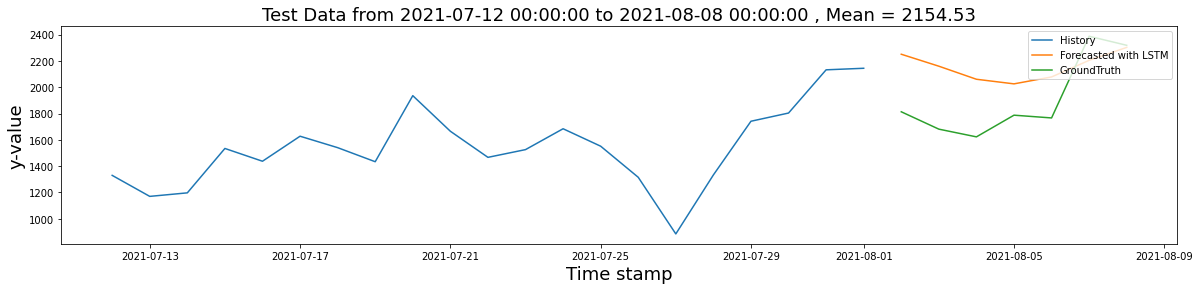

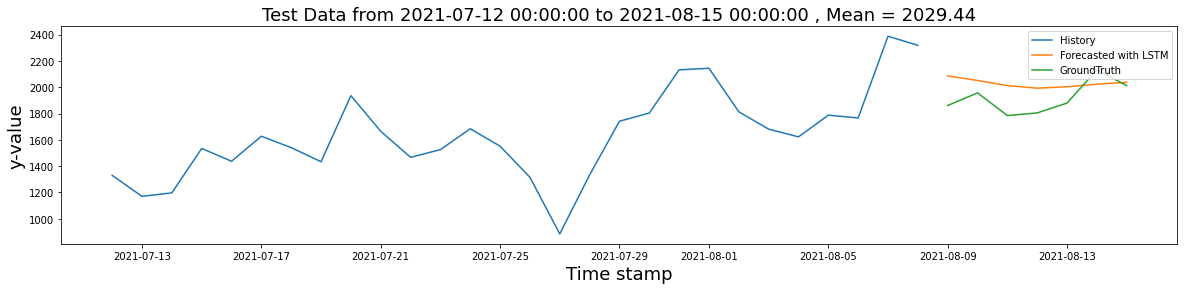

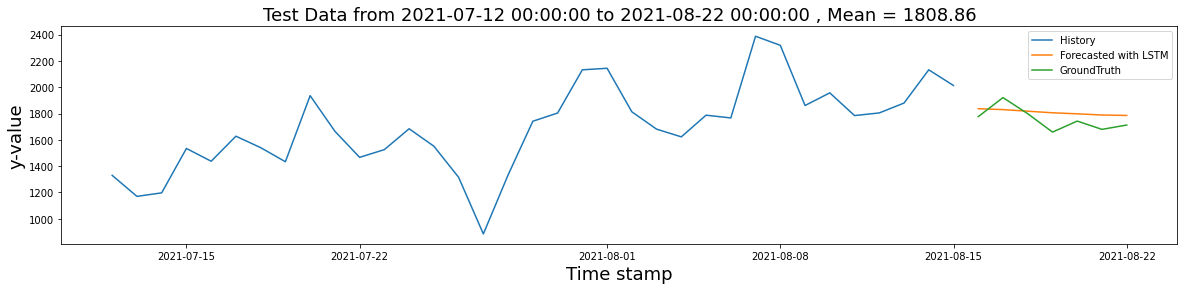

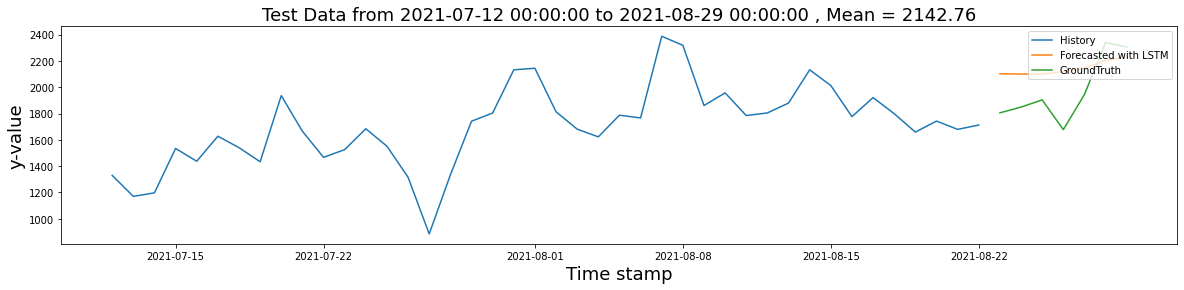

In [34]:
# all test batches

dfs1 = pd.DataFrame() # to save predictions
past = pd.DataFrame() # to save past data which is not used to evaluate metrics
error_metrics_1 = pd.DataFrame() # To save error metrics

for i in range(0,28,7):
    
    n_steps_in = 21
    n_steps_out = 7
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    
    # prepare data for time series sequence
    y_pred_inv , dataset_test_y , past_data = prep_data(test_scaled, y_test, start,
                                                        end, last, results1)
    # plot the sequence
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)
    
    # calculate errors and then return dataframe
    errors = evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , dataset_test_y.index[0],
                                 dataset_test_y.index[-1])
    
    
    # concat with previour error data frames
    error_metrics_1 = pd.concat([error_metrics_1, errors], ignore_index=False)
    
    # save past data
    past = pd.DataFrame()
    past["past"] = past_data
    
    # concat with previour past data frames
    past = pd.concat([past], ignore_index=False)
    
    # create data to save multiple colums
    d = pd.DataFrame()
    d["Ground Truth"] = dataset_test_y
    d["Predictions"] = y_pred_inv
    
    # concat with outside dataframe to save all results
    dfs1 = pd.concat([dfs1, d], ignore_index=False)

# Now merge past and predictions dataframe on date column
all_data1 = past.merge(dfs1, right_index=True, left_index=True, how="outer") 

In [35]:
all_data1.to_csv(os.path.join(forecast, "pm_lstm_d_3.csv"))

In [36]:
error_metrics_1

MSE        RMSE  \
2021-08-02 00:00:00 : 2021-08-08 00:00:00  114203.410051  337.939950   
2021-08-09 00:00:00 : 2021-08-15 00:00:00   24972.404817  158.026595   
2021-08-16 00:00:00 : 2021-08-22 00:00:00    7732.228214   87.933089   
2021-08-23 00:00:00 : 2021-08-29 00:00:00   64056.875120  253.094597   

                                                  MAE       R^2  
2021-08-02 00:00:00 : 2021-08-08 00:00:00  300.310259 -0.391124  
2021-08-09 00:00:00 : 2021-08-15 00:00:00  141.918068 -0.904024  
2021-08-16 00:00:00 : 2021-08-22 00:00:00   79.226022 -0.156455  
2021-08-23 00:00:00 : 2021-08-29 00:00:00  228.245654 -0.175169

In [37]:
fig1 = px.line(all_data1, x=all_data1.index, y=["past", "Ground Truth", "Predictions"])

fig1.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label='1 Week', step='day', stepmode='backward'),
            dict(count=14, label='2 Weeks', step='day', stepmode='backward'),
            dict(count=21, label='3 Weeks', step='day', stepmode='backward'),
            dict(step='all')
            ])
    )
)

# Show plot 
fig1.show()

## Model 2: Selected Features with shifting features values to future

In [38]:
x1 = df[['kw', 'Temperature', 'Soil_Temperature', 'Sunshine_Duration',
                 'Precipitation_Total', 'waterlevel', 'watertemperature', 'kw_8']].copy()


y = df["kw"].values
X, Y = prepare_time_series(x1.values, y)


X_train, y_train, x_test, y_test = train_test_split(X, Y)

dataset_stacked.shape (864, 10)
X.shape (864, 9)
y.shape (864,)
train_X.shape (754, 21, 9)
train_y.shape (754, 7)
test_X.shape (84, 21, 9)
test_y.shape (84, 7)
n_features 9


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 21, 50)            12000     
_________________________________________________________________
dropout_14 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 357       
Total params: 32,557
Trainable params: 32,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 3s 219ms/step - loss: 0.2236 - root_mean_squared_error: 0.4728 - v

5/5 [==============================] - 0s 12ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1751
Epoch 44/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0254 - root_mean_squared_error: 0.1592 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1673
Epoch 45/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0255 - root_mean_squared_error: 0.1595 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1551
Epoch 46/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0244 - root_mean_squared_error: 0.1564 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1829
Epoch 47/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1595
Epoch 48/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.0249 - val_root_mean_squared_error:

5/5 [==============================] - 0s 11ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494
Epoch 36/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0225 - root_mean_squared_error: 0.1499 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1487
Epoch 37/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1516
Epoch 38/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0228 - root_mean_squared_error: 0.1509 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1489
Epoch 39/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1494
Epoch 40/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0215 - root_mean_squared_error: 0.1468 - val_loss: 0.0223 - val_root_mean_squared_error:

5/5 [==============================] - 0s 13ms/step - loss: 0.0253 - root_mean_squared_error: 0.1591 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1489
Epoch 28/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0258 - root_mean_squared_error: 0.1608 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1457
Epoch 29/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0253 - root_mean_squared_error: 0.1589 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1516
Epoch 30/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 31/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1474
Epoch 32/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0210 - val_root_mean_squared_error:

4/4 [==============================] - 0s 13ms/step - loss: 0.0221 - root_mean_squared_error: 0.1486 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1445
Epoch 20/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1471
Epoch 21/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1455
Epoch 22/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0208 - root_mean_squared_error: 0.1441 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1450
Epoch 23/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0205 - root_mean_squared_error: 0.1431 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1443
Epoch 24/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0213 - root_mean_squared_error: 0.1460 - val_loss: 0.0209 - val_root_mean_squared_error:

4/4 [==============================] - 0s 15ms/step - loss: 0.0234 - root_mean_squared_error: 0.1530 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1514
Epoch 12/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1460
Epoch 13/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0212 - root_mean_squared_error: 0.1454 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1455
Epoch 14/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0209 - root_mean_squared_error: 0.1447 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1519
Epoch 15/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0199 - root_mean_squared_error: 0.1412 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1462
Epoch 16/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0198 - root_mean_squared_error: 0.1408 - val_loss: 0.0210 - val_root_mean_squared_error:

4/4 [==============================] - 0s 13ms/step - loss: 0.0410 - root_mean_squared_error: 0.2025 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1739
Epoch 4/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0328 - root_mean_squared_error: 0.1811 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1574
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1770
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1611
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1558
Epoch 8/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0258 - val_root_mean_squared_error: 0.16

6/6 [==============================] - 3s 125ms/step - loss: 0.1331 - root_mean_squared_error: 0.3649 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2188
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0569 - root_mean_squared_error: 0.2384 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1636
Epoch 3/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0403 - root_mean_squared_error: 0.2007 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1723
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1537
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1448
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558 - val_loss: 0.0205 - val_root_mean_squared_error: 0.143

6/6 [==============================] - 0s 10ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1311
Epoch 50/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1474
Best: 0.635922 using {'n_neurons': 50, 'lr': 0.01, 'epochs': 200, 'batch_size': 128}
Mean: 0.599983 (Standard Deviation: 0.113919) with: {'n_neurons': 50, 'lr': 0.001, 'epochs': 200, 'batch_size': 112}
Mean: 0.635922 (Standard Deviation: 0.079417) with: {'n_neurons': 50, 'lr': 0.01, 'epochs': 200, 'batch_size': 128}


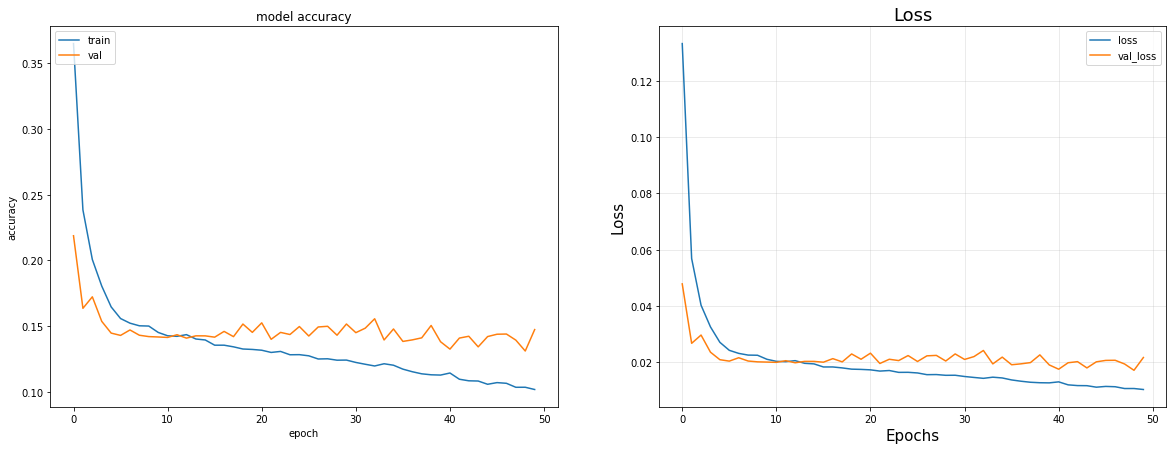

In [39]:
results2 = cross_validation(X_train, y_train, x_test, y_test)

In [40]:
# prepare test data

x_test = test_df[['kw', 'Temperature', 'Soil_Temperature', 'Sunshine_Duration',
                 'Precipitation_Total', 'waterlevel', 'watertemperature', 'kw_8']].copy()

y_test = test_df['kw']

scaler = MinMaxScaler(feature_range=(0, 1))

test_scaled = scaler.fit_transform(x_test.values)

Test Data from 2021-08-02 00:00:00 to 2021-08-08 00:00:00
Mean Square Error: 84694.45
Mean Absolute Error: 276.22
Root Mean Square Error: 291.02
R-Square: -0.03


Test Data from 2021-08-09 00:00:00 to 2021-08-15 00:00:00
Mean Square Error: 38114.98
Mean Absolute Error: 174.09
Root Mean Square Error: 195.23
R-Square: -1.91


Test Data from 2021-08-16 00:00:00 to 2021-08-22 00:00:00
Mean Square Error: 8127.07
Mean Absolute Error: 83.06
Root Mean Square Error: 90.15
R-Square: -0.22


Test Data from 2021-08-23 00:00:00 to 2021-08-29 00:00:00
Mean Square Error: 90771.88
Mean Absolute Error: 252.29
Root Mean Square Error: 301.28
R-Square: -0.67




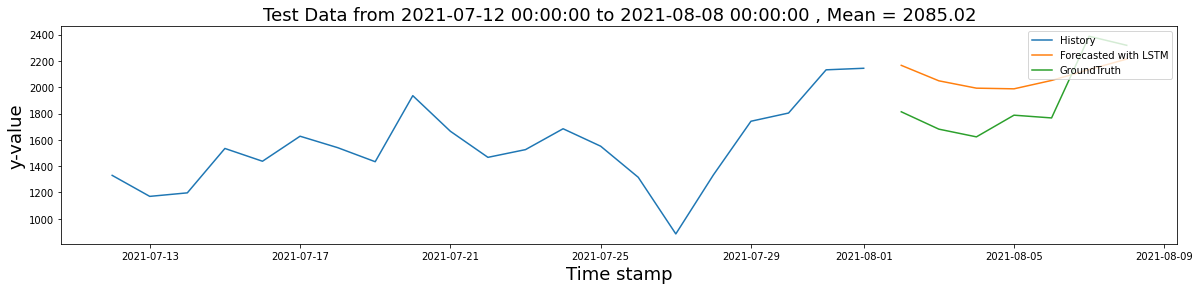

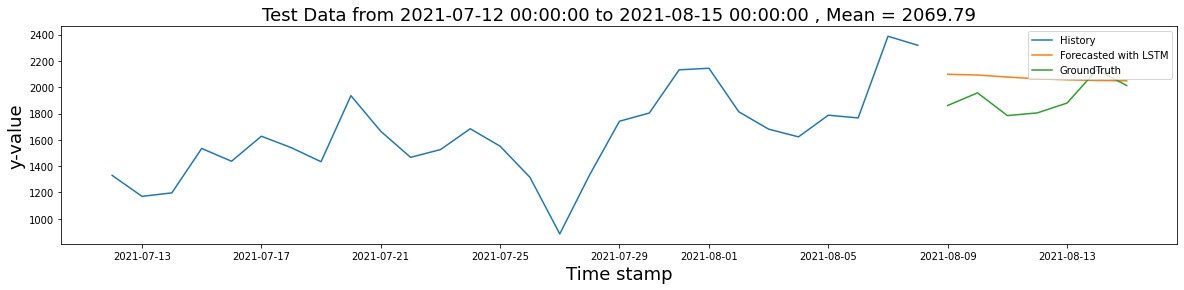

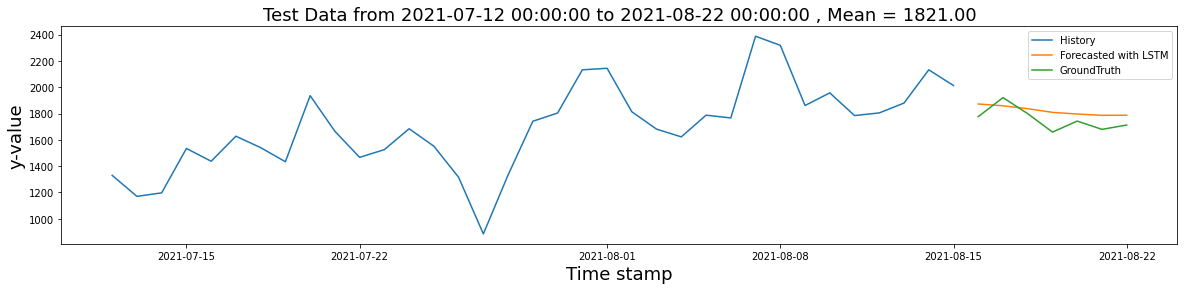

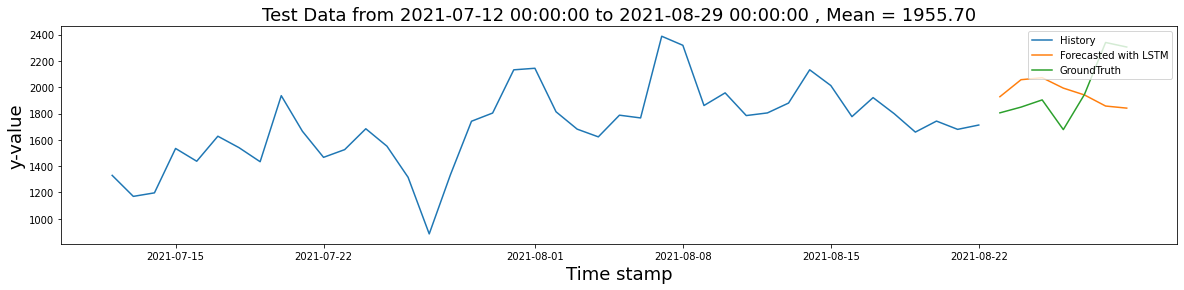

In [41]:
# all test batches

dfs2 = pd.DataFrame() # to save predictions
past = pd.DataFrame() # to save past data which is not used to evaluate metrics
error_metrics_2 = pd.DataFrame() # To save error metrics

for i in range(0,28,7):
    
    n_steps_in = 21
    n_steps_out = 7
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    
    # prepare data for time series sequence
    y_pred_inv , dataset_test_y , past_data = prep_data(test_scaled, y_test, start,
                                                        end, last, results2)
    # plot the sequence
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)
    
    # calculate errors and then return dataframe
    errors = evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , dataset_test_y.index[0],
                                 dataset_test_y.index[-1])
    
    
    # concat with previour error data frames
    error_metrics_2 = pd.concat([error_metrics_2, errors], ignore_index=False)
    
    # save past data
    past = pd.DataFrame()
    past["past"] = past_data
    
    # concat with previour past data frames
    past = pd.concat([past], ignore_index=False)
    
    # create data to save multiple colums
    d = pd.DataFrame()
    d["Ground Truth"] = dataset_test_y
    d["Predictions"] = y_pred_inv
    
    # concat with outside dataframe to save all results
    dfs2 = pd.concat([dfs2, d], ignore_index=False)

# Now merge past and predictions dataframe on date column
all_data2 = past.merge(dfs2, right_index=True, left_index=True, how="outer")  

In [42]:
all_data2.to_csv(os.path.join(forecast, "pm_lstm_d_2.csv"))

In [43]:
fig2 = px.line(all_data2, x=all_data2.index, y=["past", "Ground Truth", "Predictions"])

fig2.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label='1 Week', step='day', stepmode='backward'),
            dict(count=14, label='2 Weeks', step='day', stepmode='backward'),
            dict(count=21, label='3 Weeks', step='day', stepmode='backward'),
            dict(step='all')
            ])
    )
)

# Show plot 
fig2.show()

In [44]:
error_metrics_2

MSE        RMSE  \
2021-08-02 00:00:00 : 2021-08-08 00:00:00  84694.451756  291.023112   
2021-08-09 00:00:00 : 2021-08-15 00:00:00  38114.975655  195.230570   
2021-08-16 00:00:00 : 2021-08-22 00:00:00   8127.073965   90.150285   
2021-08-23 00:00:00 : 2021-08-29 00:00:00  90771.884280  301.283727   

                                                  MAE       R^2  
2021-08-02 00:00:00 : 2021-08-08 00:00:00  276.221218 -0.031673  
2021-08-09 00:00:00 : 2021-08-15 00:00:00  174.089629 -1.906081  
2021-08-16 00:00:00 : 2021-08-22 00:00:00   83.062099 -0.215509  
2021-08-23 00:00:00 : 2021-08-29 00:00:00  252.285192 -0.665275

## Model 3: Using past 14 days Kw values to predict future kw values

In [45]:
x1 = df["kw"]
y = df["kw"].values

X, Y = prepare_time_series(x1.values.reshape(-1, 1), y)

X_train, y_train, x_test, y_test = train_test_split(X, Y)

dataset_stacked.shape (864, 2)
X.shape (864, 1)
y.shape (864,)
train_X.shape (754, 21, 1)
train_y.shape (754, 7)
test_X.shape (84, 21, 1)
test_y.shape (84, 7)
n_features 1


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 21, 50)            10400     
_________________________________________________________________
dropout_28 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_29 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 7)                 357       
Total params: 30,957
Trainable params: 30,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 [==============================] - 3s 140ms/step - loss: 0.1801 - root_mean_squared_error: 0.4244 - 

5/5 [==============================] - 0s 11ms/step - loss: 0.0223 - root_mean_squared_error: 0.1494 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1455
Epoch 44/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 45/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0223 - root_mean_squared_error: 0.1494 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1473
Epoch 46/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0223 - root_mean_squared_error: 0.1493 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1455
Epoch 47/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0218 - root_mean_squared_error: 0.1477 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 48/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484 - val_loss: 0.0209 - val_root_mean_squared_error:

5/5 [==============================] - 0s 12ms/step - loss: 0.0209 - root_mean_squared_error: 0.1447 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1444
Epoch 36/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0205 - root_mean_squared_error: 0.1431 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504
Epoch 37/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1428
Epoch 38/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 39/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0210 - root_mean_squared_error: 0.1449 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425
Epoch 40/50
5/5 [==============================] - 0s 10ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0209 - val_root_mean_squared_error:

5/5 [==============================] - 0s 13ms/step - loss: 0.0216 - root_mean_squared_error: 0.1469 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 28/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0217 - root_mean_squared_error: 0.1474 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 29/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1535
Epoch 30/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0214 - root_mean_squared_error: 0.1461 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1539
Epoch 31/50
5/5 [==============================] - 0s 11ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1536
Epoch 32/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0217 - root_mean_squared_error: 0.1473 - val_loss: 0.0236 - val_root_mean_squared_error:

4/4 [==============================] - 0s 13ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1581
Epoch 20/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 21/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565
Epoch 22/50
4/4 [==============================] - 0s 12ms/step - loss: 0.0260 - root_mean_squared_error: 0.1613 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 23/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0257 - root_mean_squared_error: 0.1604 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1592
Epoch 24/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0254 - root_mean_squared_error: 0.1594 - val_loss: 0.0235 - val_root_mean_squared_error:

4/4 [==============================] - 0s 14ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1614
Epoch 12/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1672
Epoch 13/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0286 - root_mean_squared_error: 0.1692 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1599
Epoch 14/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0281 - root_mean_squared_error: 0.1676 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1603
Epoch 15/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0275 - root_mean_squared_error: 0.1657 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600
Epoch 16/50
4/4 [==============================] - 0s 15ms/step - loss: 0.0259 - root_mean_squared_error: 0.1609 - val_loss: 0.0247 - val_root_mean_squared_error:

4/4 [==============================] - 0s 13ms/step - loss: 0.0484 - root_mean_squared_error: 0.2199 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 4/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1625
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1730
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0310 - root_mean_squared_error: 0.1759 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1617
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 0.0301 - root_mean_squared_error: 0.1735 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1636
Epoch 8/50
4/4 [==============================] - 0s 13ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715 - val_loss: 0.0246 - val_root_mean_squared_error: 0.15

7/7 [==============================] - 3s 98ms/step - loss: 0.1072 - root_mean_squared_error: 0.3275 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0422 - root_mean_squared_error: 0.2054 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1582
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0342 - root_mean_squared_error: 0.1850 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1638
Epoch 4/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0311 - root_mean_squared_error: 0.1765 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1563
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0287 - root_mean_squared_error: 0.1694 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0268 - root_mean_squared_error: 0.1638 - val_loss: 0.0240 - val_root_mean_squared_error: 0.15

7/7 [==============================] - 0s 9ms/step - loss: 0.0188 - root_mean_squared_error: 0.1372 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299
Epoch 50/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0188 - root_mean_squared_error: 0.1372 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1316
Best: 0.550619 using {'n_neurons': 50, 'lr': 0.01, 'epochs': 200, 'batch_size': 112}
Mean: 0.550619 (Standard Deviation: 0.095498) with: {'n_neurons': 50, 'lr': 0.01, 'epochs': 200, 'batch_size': 112}
Mean: 0.533526 (Standard Deviation: 0.114296) with: {'n_neurons': 50, 'lr': 0.01, 'epochs': 200, 'batch_size': 128}


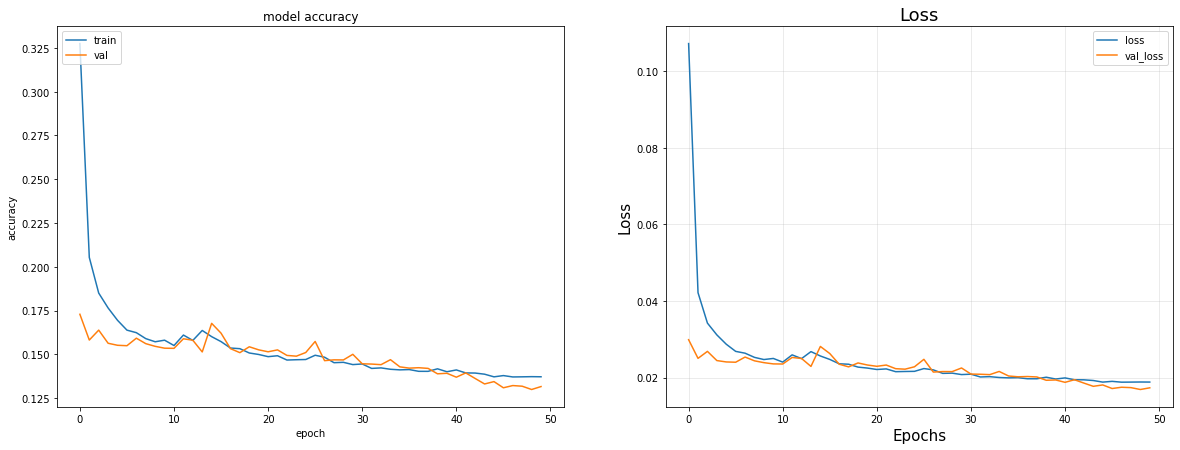

In [46]:
results3 = cross_validation(X_train, y_train, x_test, y_test)

In [47]:
# prepare test data

x_test = test_df['kw'].values.reshape(-1, 1)
y_test = test_df['kw'] 

scaler = MinMaxScaler(feature_range=(0, 1))

test_scaled = scaler.fit_transform(x_test)

Test Data from 2021-08-02 00:00:00 to 2021-08-08 00:00:00
Mean Square Error: 109348.83
Mean Absolute Error: 315.73
Root Mean Square Error: 330.68
R-Square: -0.33


Test Data from 2021-08-09 00:00:00 to 2021-08-15 00:00:00
Mean Square Error: 24037.47
Mean Absolute Error: 139.64
Root Mean Square Error: 155.04
R-Square: -0.83


Test Data from 2021-08-16 00:00:00 to 2021-08-22 00:00:00
Mean Square Error: 10581.58
Mean Absolute Error: 92.59
Root Mean Square Error: 102.87
R-Square: -0.58


Test Data from 2021-08-23 00:00:00 to 2021-08-29 00:00:00
Mean Square Error: 53752.70
Mean Absolute Error: 210.14
Root Mean Square Error: 231.85
R-Square: 0.01




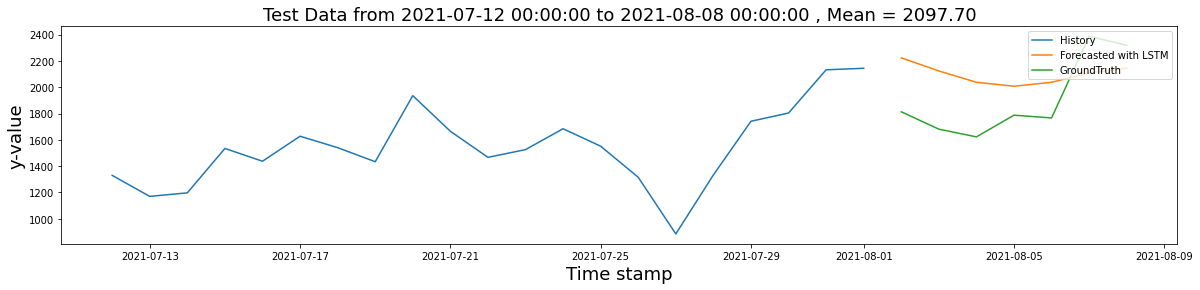

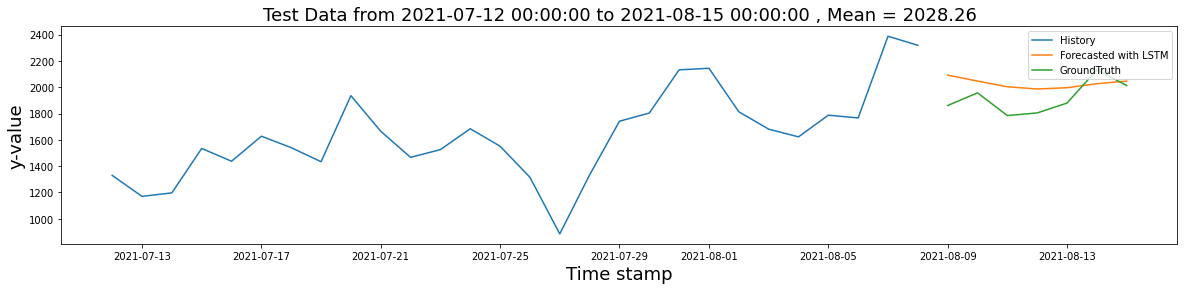

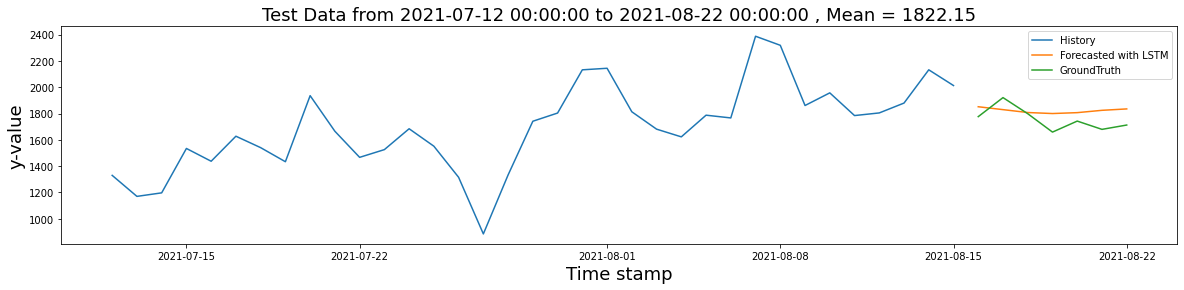

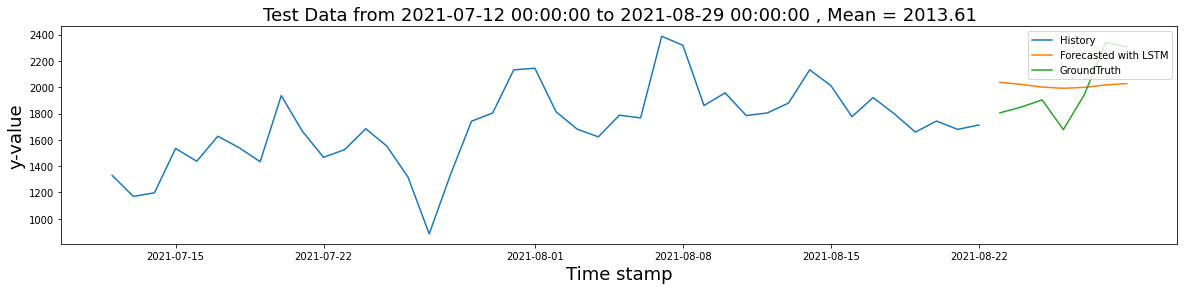

In [48]:
# all test batches

dfs3 = pd.DataFrame() # to save predictions
past = pd.DataFrame() # to save past data which is not used to evaluate metrics
error_metrics_3 = pd.DataFrame() # To save error metrics

for i in range(0,28,7):
    
    n_steps_in = 21
    n_steps_out = 7
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    
    # prepare data for time series sequence
    y_pred_inv , dataset_test_y , past_data = prep_data(test_scaled, y_test, start,
                                                        end, last, results3)
    # plot the sequence
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)
    
    # calculate errors and then return dataframe
    errors = evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , dataset_test_y.index[0],
                                 dataset_test_y.index[-1])
    
    
    # concat with previour error data frames
    error_metrics_3 = pd.concat([error_metrics_3, errors], ignore_index=False)
    
    # save past data
    past = pd.DataFrame()
    past["past"] = past_data
    
    # concat with previour past data frames
    past = pd.concat([past], ignore_index=False)
    
    # create data to save multiple colums
    d = pd.DataFrame()
    d["Ground Truth"] = dataset_test_y
    d["Predictions"] = y_pred_inv
    
    # concat with outside dataframe to save all results
    dfs3 = pd.concat([dfs3, d], ignore_index=False)

# Now merge past and predictions dataframe on date column
all_data3 = past.merge(dfs3, right_index=True, left_index=True, how="outer")  

In [49]:
all_data3.to_csv(os.path.join(forecast, "pm_lstm_d_1.csv"))

In [50]:
fig3 = px.line(all_data3, x=all_data3.index, y=["past", "Ground Truth", "Predictions"])

fig3.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label='1 Week', step='day', stepmode='backward'),
            dict(count=14, label='2 Weeks', step='day', stepmode='backward'),
            dict(count=21, label='3 Weeks', step='day', stepmode='backward'),
            dict(step='all')
            ])
    )
)

# Show plot 
fig3.show()

In [51]:
error_metrics_3

MSE        RMSE  \
2021-08-02 00:00:00 : 2021-08-08 00:00:00  109348.834379  330.679353   
2021-08-09 00:00:00 : 2021-08-15 00:00:00   24037.470425  155.040222   
2021-08-16 00:00:00 : 2021-08-22 00:00:00   10581.581582  102.866815   
2021-08-23 00:00:00 : 2021-08-29 00:00:00   53752.698281  231.846282   

                                                  MAE       R^2  
2021-08-02 00:00:00 : 2021-08-08 00:00:00  315.728106 -0.331990  
2021-08-09 00:00:00 : 2021-08-15 00:00:00  139.639573 -0.832740  
2021-08-16 00:00:00 : 2021-08-22 00:00:00   92.588536 -0.582612  
2021-08-23 00:00:00 : 2021-08-29 00:00:00  210.143045  0.013868

In [52]:
from ipylab import JupyterFrontEnd

app = JupyterFrontEnd()
app.commands.execute('docmanager:save')